In [1]:
library(rjags)
library(runjags)
library(R2jags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




In [2]:
tot_vaccine <- 1005
tot_placebo <- 978
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 0
pos_placebo <- 16
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
pfizer.tb <- tibble::tibble(tested = tested, patient=patient)
table(pfizer.tb[[2]], pfizer.tb[[1]])

         
           Neg  Pos
  Placebo  962   16
  Vaccine 1005    0

In [3]:
dataList = list(
    tested = ifelse(pfizer.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(pfizer.tb$patient)),
    Ntot = nrow(pfizer.tb) ,
    Nclass = nlevels(factor(pfizer.tb$patient))
)

In [4]:
modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Pfizer(12,15)_model.txt")

In [5]:
pfizer_chains <- run.jags(modelString ,
                          sample = 15000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Tue Jun 22 13:02:43 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1983
   Unobserved stochastic nodes: 2
   Total graph size: 3975
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not req

In [6]:
summary(pfizer_chains)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],1.02373e-02,0.017328550,0.02561630,0.017597327,0.004000762,NA,2.011849e-05,0.5,39545,-0.003763891,1.0000286
theta[2],2.39345e-04,0.002433625,0.00574658,0.002714926,0.001558611,NA,7.793056e-06,0.5,40000,0.005003780,0.9999829
theta[3],6.36579e+01,85.984550000,98.69390000,83.741603377,10.324161361,NA,5.162081e-02,0.5,40000,0.002565812,1.0000324


In [7]:
add.summary(pfizer_chains)

Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 60000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
            Lower95    Median  Upper95      Mean        SD Mode       MCerr
theta[1]    0.01008  0.017313 0.025488  0.017599 0.0040024   -- 0.000016482
theta[2] 0.00024769 0.0024219 0.005741 0.0027106 0.0015596   --  6.3431e-06
theta[3]     63.669        86   98.602    83.767    10.335   --     0.04203
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.4 58971 -0.0037639    1
theta[2]     0.4 60451  0.0050038    1
theta[3]     0.4 60459  0.0025658    1

Total time taken: 2.8 seconds


In [8]:
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



In [9]:
pfizer_res    <- tidybayes::tidy_draws(pfizer_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

In [10]:
pfizer.mcmc <- as.mcmc(pfizer_res)
pfizer.data <- as.data.frame(pfizer.mcmc)

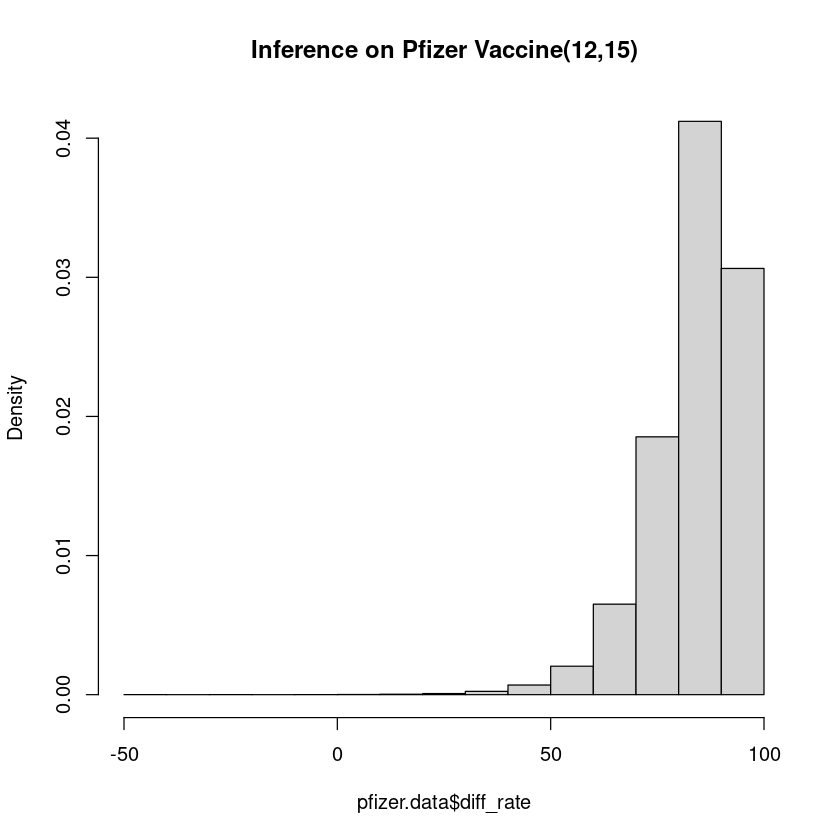

In [11]:
hist(pfizer.data$diff_rate,freq=FALSE,main='Inference on Pfizer Vaccine(12,15)')

In [12]:
bayestestR::describe_posterior(pfizer.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,89.16933,0.95,63.66941,98.60182,0.9999167


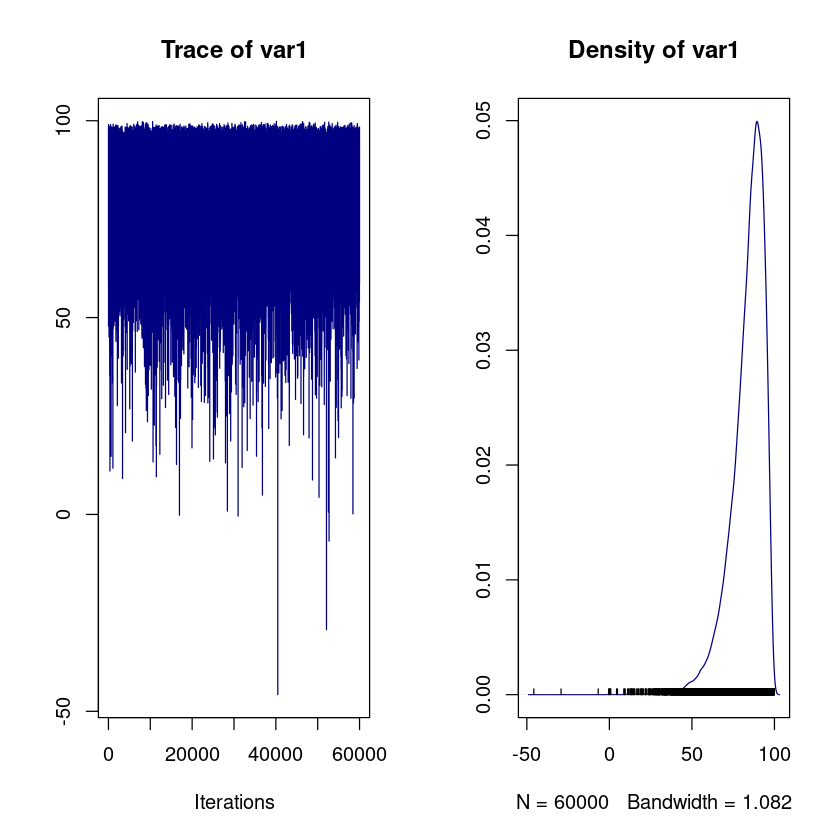

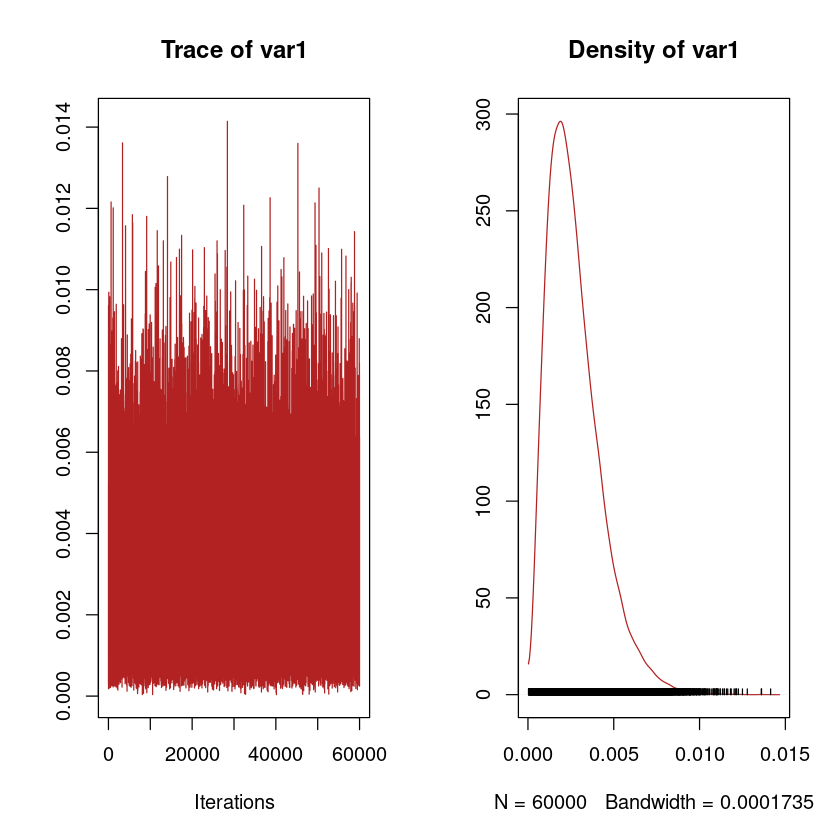

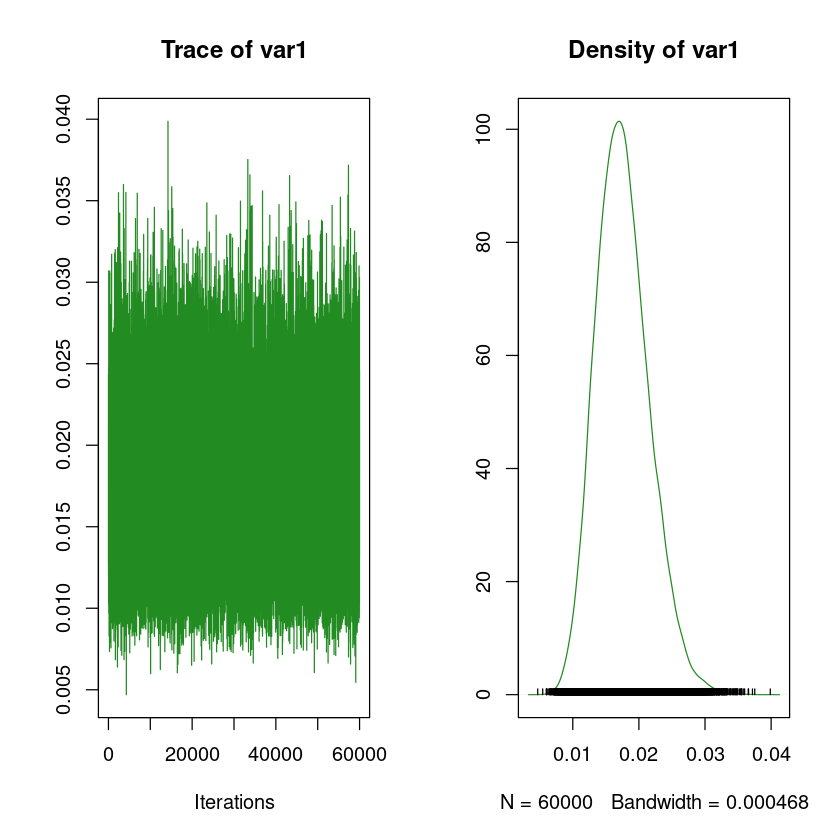

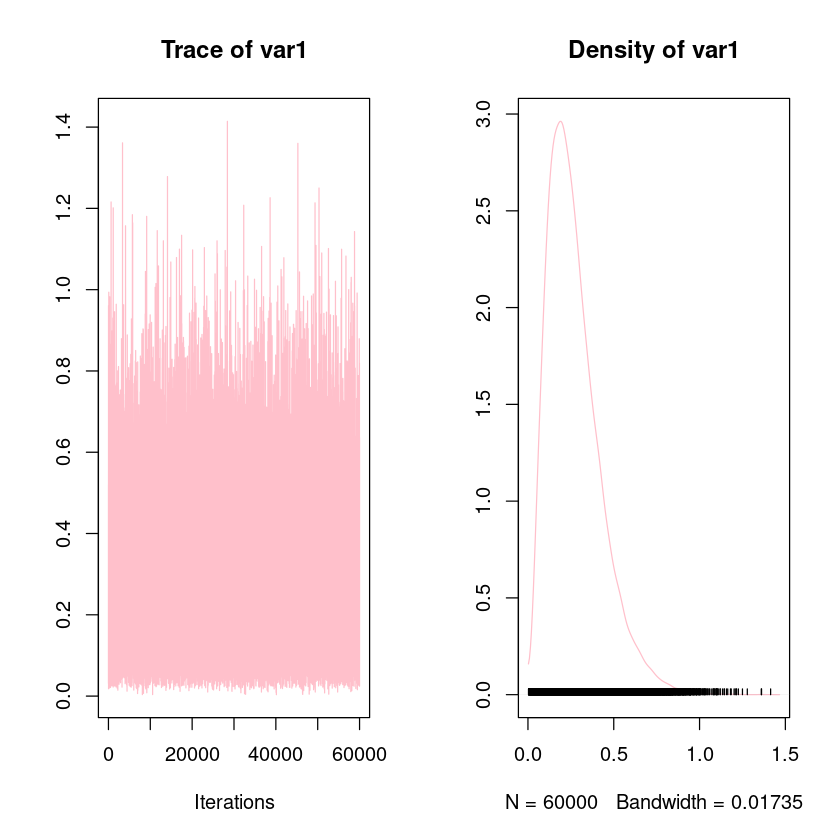

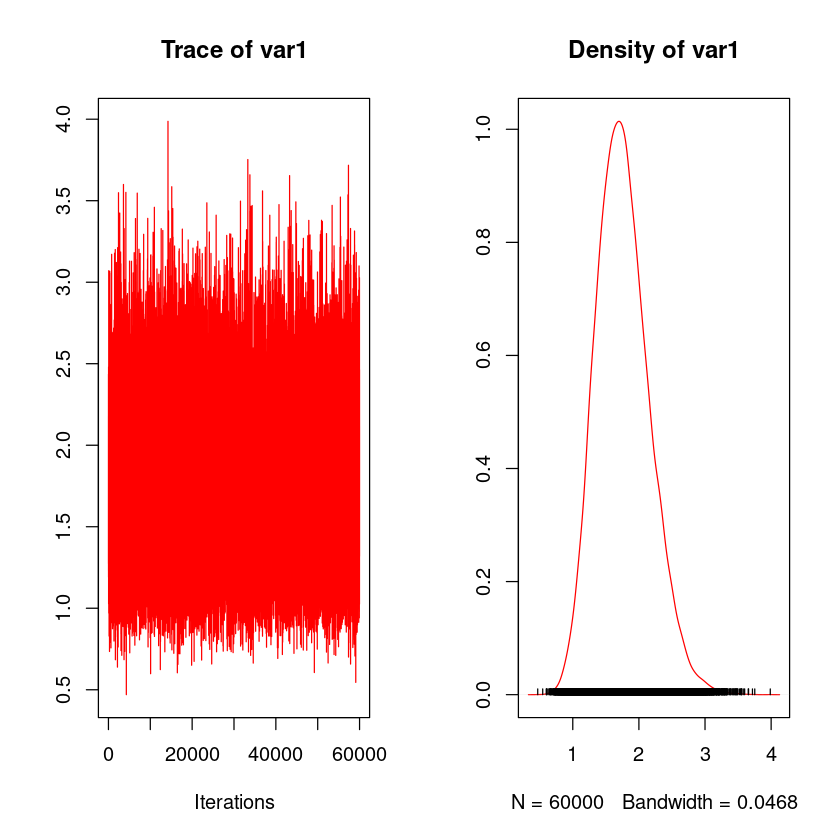

In [13]:
plot(pfizer.mcmc[,'diff_rate'],col='navy')
plot(pfizer.mcmc[,'Vaccine'],col='firebrick')
plot(pfizer.mcmc[,'Placebo'],col='forestgreen')
plot(pfizer.mcmc[,'Vaccine_perc'],col='gold')
plot(pfizer.mcmc[,'Placebo_perc'],col='red')